# Distribution of the data related by the following paper: 

### Investigating the effect of grain structure on compressive response of open-cell metal foam using high-fidelity crystal-plasticity modeling 

__Authors:__  _Dongfang Zhao, Kristoffer E. Matheson, Brian R. Phung, Steve Petruzza, Michael W. Czabaj, Ashley D. Spear_ 

__Published in:__  Materials Science and Engineering, Volume 812, 2021, 140847, ISSN 0921-5093

https://doi.org/10.1016/j.msea.2021.140847

https://www.sciencedirect.com/science/article/pii/S0921509321001167

In [ ]:
def InstallPrerequisites():

    # Pre-requirements: install all the python libraries needed to run this exemple.
    # You may need to restart the kernel if the process catches a missing library to be installed. 
    import os,sys

    # specific prerequisite (this may need to be completed)
    !"{sys.executable}" -m pip  install --upgrade OpenVisus
    !"{sys.executable}" -m OpenVisus configure 

    # general prerequisites
    !"{sys.executable}" -m pip install PIL
    !"{sys.executable}" -m pip install urllib
    !"{sys.executable}" -m pip install matplotlib
    !"{sys.executable}" -m pip install mpl_interactions
    !"{sys.executable}" -m pip install ipywidgets
    !"{sys.executable}" -m pip install ipympl 
    !"{sys.executable}" -m pip install ipycanvas
    !"{sys.executable}" -m jupyter nbextension enable --py widgetsnbextension

    print("WARNING: you probably need to restart Jupyter")
    
InstallPrerequisites()

In [2]:
import os,sys
#sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")
from OpenVisus import *
from ipywidgets import *
print(os.getcwd() )

Starting OpenVisus C:\projects\OpenVisus\build\RelWithDebInfo\OpenVisus\__init__.py 3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)] sys.version_info(major=3, minor=8, micro=6, releaselevel='final', serial=0) ...
C:\projects\OpenVisus\Samples\jupyter


In [17]:
from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt

def Assert(cond):
    if not cond:
        raise Exception("Assert failed")
        
def LoadImage(filename):
	if filename.startswith('http'):
		filename=urlopen(filename) 
	return numpy.asarray(Image.open(filename))

def ShowImage(data,width=10):
	ratio=float(data.shape[1])/data.shape[0]
	fig = plt.figure(figsize = (width,width*ratio))
	ax = fig.add_subplot(1,1,1)
	ax.imshow(data, origin='lower')
	plt.show()
    
# function to read data from a remote dataset
# optional parameters: timestep, field (variable in the dataset), logic_box (bounding box of the query), resolution

# Note: the resolution value could sometime fetch a dataset with the wrong aspect ratio, 
# this because in the IDX format we double the size at each resolution on only one of the axis at a time

# function to plot the image data with matplotlib
# optional parameters: colormap, existing plot to reuse (for more interactivity)
def ShowData(data, cmap=None, plot=None):
    #print(data)
    if(plot==None or cmap!=None):
        width = 6
        ratio=float(data.shape[1])/data.shape[0]
        fig = plt.figure(figsize = (width,width*ratio))
        plot = plt.imshow(data, origin='lower', cmap=cmap)
        plt.show()
        return plot
    else:
        plot.set_data(data)
        plt.show()
        return plot
    

# function to create a local dataset from a remote one (typically S3 object storage)
def EnableCaching(local_filename, remote_url):

    print("local_filename",local_filename)
    print("remote_url",remote_url)

    access_config="""
    <access type='multiplex'>
            <access type='disk' chmod='rw' url='file://{}' />
            <access type="CloudStorageAccess" url='{}' chmod="r" /> 
    </access>  
    """.format(
        local_filename.replace("&","&amp;"),
        remote_url.replace("&","&amp;")) 
    print("access_config",access_config)

    access= db.createAccessForBlockQuery(StringTree.fromString(access_config))

    # at this point the cache is enabled with the new local idx file
    Assert(os.path.isfile(local_filename))

    return access
    
    
# utility to copy a dataset block-by block (you can run it in the background)
def CacheAllDataset(db,access, limit, background):
    
    if background:
        thread = threading.Thread(target=CacheAllDataset, args=(db,access,limit,False))
        thread.start()        
        return thread
    
    print("CacheAllDataset","...")
        
    def ReturnValue():
        access.endRead()
        print("CacheAllDataset done")
        return True
        
    access.beginRead()
        
    cont=0
    for time in db.getTimesteps().asVector():
        for field in db.getFields():
            for blockid in range(db.getTotalNumberOfBlocks()):
                # print("Copying block","time",time,"field",field,"blockid",blockid,"...")
                buffer = db.readBlock(blockid, field=field, time=time, access=access)
                cont+=1
                if limit>0 and cont>=limit: 
                    return ReturnValue()
                
    return ReturnValue()
    
    
print("Utilities defined")

Utilities defined


In [15]:
# create data access method from a dataset stored on the cloud
# important: you should know the layour and compression in advance
url="https://s3.us-west-1.wasabisys.com/visus-server-foam/visus.idx?compression={}&layout={}".format("zip","hzorder")
db=LoadDataset(url)
print("Loaded dataset",url)

local_filename=os.path.abspath("./visus-cache/foam/visus.idx").replace("\\","/")
print("local_filename",local_filename)

Loaded dataset https://s3.us-west-1.wasabisys.com/visus-server-foam/visus.idx?compression=zip&layout=hzorder
local_filename C:/projects/OpenVisus/Samples/jupyter/visus-cache/foam/visus.idx


Now you can run a background process that slowly copy blocks from remote location

In [18]:
# if you want to copy the dataset in background
if True:
    # this create also the local_filename, important to call this before LoadDataset
    local_access=EnableCaching(local_filename, url) 
    local_db=LoadDataset(local_filename)
    thread=CacheAllDataset(local_db,local_access,0,True)

local_filename C:/projects/OpenVisus/Samples/jupyter/visus-cache/foam/visus.idx
remote_url https://s3.us-west-1.wasabisys.com/visus-server-foam/visus.idx?compression=zip&layout=hzorder
access_config 
    <access type='multiplex'>
            <access type='disk' chmod='rw' url='file://C:/projects/OpenVisus/Samples/jupyter/visus-cache/foam/visus.idx' />
            <access type="CloudStorageAccess" url='https://s3.us-west-1.wasabisys.com/visus-server-foam/visus.idx?compression=zip&amp;layout=hzorder' chmod="r" /> 
    </access>  
    
CacheAllDataset ...


In [20]:
X_size,Y_size,Z_size = db.getLogicBox()[1]
slice_value = int(Z_size/2)

print("Database size",X_size,Y_size,Z_size )
print("slice_value",slice_value)
print("fields:",db.getFields())

Database size 1055 1024 1024
slice_value 512
fields: ['data', 'dist']


In [21]:
# create a plot for our data
access=EnableCaching(local_filename, url)
first_query = db.read(x=[slice_value,slice_value+1],y=[0,Y_size],z=[0,Z_size], num_refinements=1 , quality=-3, access = access).reshape([Y_size//2,Z_size//2])
print("First query done")

local_filename C:/projects/OpenVisus/Samples/jupyter/visus-cache/foam/visus.idx
remote_url https://s3.us-west-1.wasabisys.com/visus-server-foam/visus.idx?compression=zip&layout=hzorder
access_config 
    <access type='multiplex'>
            <access type='disk' chmod='rw' url='file://C:/projects/OpenVisus/Samples/jupyter/visus-cache/foam/visus.idx' />
            <access type="CloudStorageAccess" url='https://s3.us-west-1.wasabisys.com/visus-server-foam/visus.idx?compression=zip&amp;layout=hzorder' chmod="r" /> 
    </access>  
    
First query done


In [22]:
# if running this code in a Jupter notbeook or JupyterLab
# NOTE I need this cell to be one line only with only this op
%matplotlib notebook 

<IPython.core.display.Javascript object>


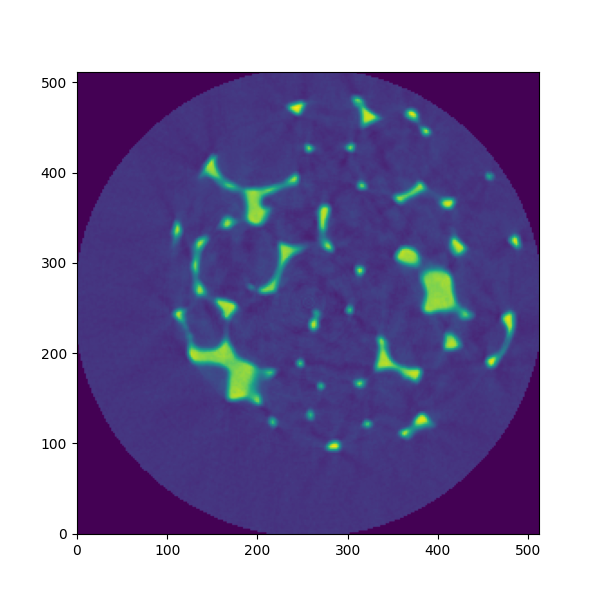

interactive(children=(IntSlider(value=0, description='time', max=3), Dropdown(description='Slice orthogonal to…

<function __main__.<lambda>(time, direction, xslice, res_widget)>

In [24]:
# create a plot for our data
myplot = ShowData(first_query)
slice_dir = 0
resolution = 2
#myplot = None
width = 6
#ratio=float(data.shape[2])/data.shape[1])
#fig = plt.figure(figsize = (width,width*ratio))

time  =widgets.IntSlider(value=0,min=0,max=3,step=1)
direction = widgets.Dropdown(options=[('X', 0), ('Y', 1), ('Z', 2)], value=0,description='Slice orthogonal to axis:')
xslice=widgets.IntSlider(value=500,min=0,max=X_size-1,step=1,description="slice")
res_widget =widgets.IntSlider(value=-2,min=-5,max=0,step=1,description="Resolution")

# function to plot the image data with matplotlib
# optional parameters: colormap, existing plot to reuse (for more interactivity)
def ShowSlice(time=0,direction = slice_dir,slice_position=700,new_resolution = resolution,db=db, cmap=None, plot=myplot):
    global myplot, first_query, slice_dir, xslice, resolution
    plot = myplot
    print (time,direction,slice_position,new_resolution,db, cmap, plot)
    if  slice_dir != direction :    
        #print("Direction changed from ", slice_dir," to ", direction)
        xslice.max = db.getLogicBox()[1][direction]-1        
        xslice.value = 512
        
    slice_dir  = direction
    resolution = new_resolution
    
    #print(time,slice_dir,slice_position+1)
    #print  (time, slice_dir,[slice_position,slice_position+1],[0,Y_size],[0,Z_size])
    data_quality = resolution *2
    New_quality = new_resolution*3
    size_denominator = int(2**(new_resolution*-1))
    
    actual_slice_position = slice_position //size_denominator
    actual_slice_position = actual_slice_position *size_denominator
    
    print("> ",New_quality,size_denominator,actual_slice_position)
    try:
        if  slice_dir == 0:  
                data = db.read(time=time, 
                    x=[actual_slice_position,actual_slice_position+1],
                    y=[0,Y_size],
                    z=[0,Z_size], 
                    num_refinements=1 , 
                    quality=New_quality, 
                    access = access).reshape([Y_size//size_denominator,Z_size//size_denominator])
        elif slice_dir == 1:
                data = db.read(time=time, 
                    x=[0,Y_size],
                    y=[actual_slice_position,actual_slice_position+1],
                    z=[0,Z_size], 
                    num_refinements=1 , 
                    quality=New_quality, 
                    access = access).reshape([Y_size//size_denominator,Z_size//size_denominator])
        else :
                data = db.read(time=time, 
                    x=[0,Y_size],
                    y=[0,Z_size], 
                    z=[actual_slice_position,actual_slice_position+1],
                    num_refinements=1 , 
                    quality=New_quality, 
                    access = access).reshape([Y_size//size_denominator,Z_size//size_denominator])
            
    except:
        data = first_query
    first_query = data
    #print(data)
    if(plot==None or cmap!=None):
        print("===================== PROBLEM!!!! =======================================")
        return plot
    else:
        #print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        #plot.
        plot.set_data(data)
        plt.show()
        return plot

# reuse the plot with an interact for varying time and resolution values
interact(lambda time, direction,xslice, res_widget: ShowSlice(time, direction,xslice, res_widget), 
         time  = time, direction = direction, xslice=xslice, res_widget = res_widget)